In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Rescaling, Conv2D, MaxPool2D, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from skimage.transform import resize
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

import pickle
import cv2
import glob
import imageio

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Read data set

In [5]:
test_data = pd.read_csv('/content/drive/MyDrive/Deep_learning_data/keypoints-images/test.csv')
train_data = pd.read_csv('/content/drive/MyDrive/Deep_learning_data/keypoints-images/training.csv')

### Count missing values

In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7049 entries, 0 to 7048
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          7039 non-null   float64
 1   left_eye_center_y          7039 non-null   float64
 2   right_eye_center_x         7036 non-null   float64
 3   right_eye_center_y         7036 non-null   float64
 4   left_eye_inner_corner_x    2271 non-null   float64
 5   left_eye_inner_corner_y    2271 non-null   float64
 6   left_eye_outer_corner_x    2267 non-null   float64
 7   left_eye_outer_corner_y    2267 non-null   float64
 8   right_eye_inner_corner_x   2268 non-null   float64
 9   right_eye_inner_corner_y   2268 non-null   float64
 10  right_eye_outer_corner_x   2268 non-null   float64
 11  right_eye_outer_corner_y   2268 non-null   float64
 12  left_eyebrow_inner_end_x   2270 non-null   float64
 13  left_eyebrow_inner_end_y   2270 non-null   float

### Only take 50 images

In [7]:
#train_data_50 = train_data.head(50)
#test_data_50 = test_data.head(50)

In [8]:
train_data = train_data.dropna(axis=0)

### Convert type of images column and store it in array of arrays

In [9]:
def get_features_from_data(df_data):
    X_list = [x for x in df_data['Image'].str.split(' ')]
    X = np.asarray(X_list, dtype=np.float32)
    return X

### Store target in np.array

In [10]:
def get_target_from_data(df_data):
    facial_pts_data = df_data.drop(['Image'], axis=1)
        
    facial_pts = []

    for i in range(len(facial_pts_data)):
        facial_pts.append(facial_pts_data.iloc[i])

    y = np.array(facial_pts, dtype='float')
    return y

In [11]:
X = get_features_from_data(train_data)

In [12]:
y = get_target_from_data(train_data)

In [13]:
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
y = imputer.fit_transform(y)

In [14]:
sum(np.isnan(y))

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])

### Convert target to x, y array

In [15]:
def get_coordinates(df_target):
    coords = []

    for i in range(len(df_target)):
        for j in range(0,df_target.shape[1],2):
            coords.append([df_target.iloc[i,j],df_target.iloc[i,j+1]])

    coords = np.array(coords)
    return coords

In [16]:
coords = get_coordinates(train_data.drop(['Image'], axis=1))

In [17]:
pd.DataFrame(y).head(2)

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,44.420571,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,...,48.206298,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170


### Randomly plot training set and his keypoints

In [18]:
def plot_keypoints_and_image(X, y, y_pred=None, img_number=9, id=0):
    plt.figure(figsize= (8,8))
    for row in range(1, img_number+1, 1):
        rand_id = np.random.randint(len(X))
        if id != 0:
          rand_id = id
        image = X[rand_id]
        plt.subplot(3,3,row)
        plt.imshow(X[rand_id].reshape(96,96), cmap='gray')
        plt.scatter(y[rand_id:rand_id+15,0],y[rand_id:rand_id+15,1], color='blue', label='actual')
        if y_pred is not None :
          plt.scatter(y_pred[rand_id:rand_id+15,0],y_pred[rand_id:rand_id+15,1], color='orange',label='predicted')
        plt.legend()
        plt.title(rand_id)
        plt.xticks(())
        plt.yticks(())
    plt.show()

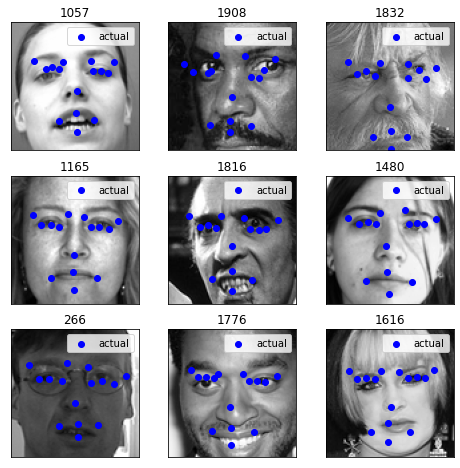

In [19]:
plot_keypoints_and_image(X, coords)

In [20]:
X.shape

(2140, 9216)

### Reshape images

In [21]:
X = np.reshape(X, (len(X),96,96,1))

### Rescale images

In [22]:
X = X/255.

In [78]:
def preprocess(X):
  #reshape image
  X = np.reshape(X, (len(X),96,96,1))
  #rescale image
  X = X/255.
  return X

### Modelling

In [23]:
def initialize_model():
    model = Sequential()
    #model.add(Rescaling(scale=1./255.))
    #model.add(Reshape(input_shape=(96*96,),target_shape=(96,96,1)))
    model.add(Conv2D(16, (3,3),input_shape=(96,96,1), padding='same', activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(30, activation='linear'))
    model.compile(loss='mse',
                  optimizer='adam',
                  metrics=['mae'])
    return model

In [24]:
model = initialize_model()

In [25]:
es = EarlyStopping(patience=4, restore_best_weights=False)

### Split train and test set

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

### Train model with validation set and early stopping

In [27]:
y_train

array([[65.11297297, 38.64551351, 30.51827027, ..., 72.01913514,
        44.35621622, 80.56605405],
       [64.1664    , 34.18775273, 30.624     , ..., 67.46996364,
        47.78530909, 80.99141818],
       [67.5504    , 35.77056   , 29.79552   , ..., 67.51872   ,
        46.0992    , 82.10592   ],
       ...,
       [64.70951724, 36.40121379, 30.92965517, ..., 72.15393103,
        46.95668966, 79.05765517],
       [68.64784615, 34.25584615, 26.56984615, ..., 78.19015385,
        49.25907692, 87.88476923],
       [61.7191448 , 36.16958212, 30.59669582, ..., 71.31930619,
        46.88253895, 80.61890969]])

In [28]:
history = model.fit(X_train, y_train, epochs=750, batch_size=32, validation_split=0.3, callbacks=[es])

Epoch 1/750
33/33 [==============================] - 9s 16ms/step - loss: 1455.9387 - mae: 31.4080 - val_loss: 348.1855 - val_mae: 14.2213
Epoch 2/750
33/33 [==============================] - 0s 8ms/step - loss: 556.2032 - mae: 18.3175 - val_loss: 70.3250 - val_mae: 5.7322
Epoch 3/750
33/33 [==============================] - 0s 8ms/step - loss: 347.3946 - mae: 14.4050 - val_loss: 36.7483 - val_mae: 4.2149
Epoch 4/750
33/33 [==============================] - 0s 8ms/step - loss: 268.5567 - mae: 12.7363 - val_loss: 34.1668 - val_mae: 4.2261
Epoch 5/750
33/33 [==============================] - 0s 8ms/step - loss: 220.5769 - mae: 11.5222 - val_loss: 45.9890 - val_mae: 5.3817
Epoch 6/750
33/33 [==============================] - 0s 8ms/step - loss: 193.4402 - mae: 10.7982 - val_loss: 53.2704 - val_mae: 6.0129
Epoch 7/750
33/33 [==============================] - 0s 8ms/step - loss: 171.8989 - mae: 10.1746 - val_loss: 34.8597 - val_mae: 4.7406
Epoch 8/750
33/33 [==============================] 

In [29]:
pickle.dump(model, open('/content/drive/MyDrive/Deep_learning_data/keypoints-images/model_keypoints_detection.pkl', 'wb'))

In [30]:
train_mae = history.history['mae']
val_mae = history.history['val_mae']

### Plotting train and validation mae

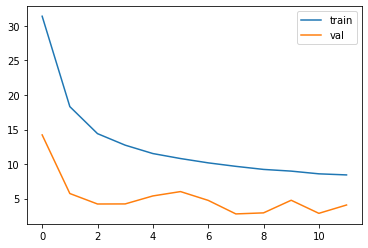

In [31]:
plt.plot(train_mae, label='train')
plt.plot(val_mae, label='val')
plt.legend(loc="upper right")
plt.show()

### Predict on Test set

In [32]:
#X_test = get_features_from_data(test_data)

In [33]:
y_pred = model.predict(X_test)

21/21 [==============================] - 0s 3ms/step


In [34]:
y_pred[0]

array([61.285572, 33.59861 , 27.815382, 33.908157, 55.486412, 34.632812,
       66.94734 , 34.987705, 33.992687, 34.15029 , 20.52042 , 35.240616,
       52.656868, 26.683903, 72.677704, 27.909262, 36.21476 , 27.147495,
       15.251594, 28.448687, 43.086258, 52.306236, 58.27277 , 69.32475 ,
       30.115423, 68.40359 , 44.55035 , 63.96529 , 44.21836 , 75.45261 ],
      dtype=float32)

In [35]:
coords_pred = get_coordinates(pd.DataFrame(y_pred))
coords_actual = get_coordinates(pd.DataFrame(y_test))

### Randomly plot test set and his predicted keypoints

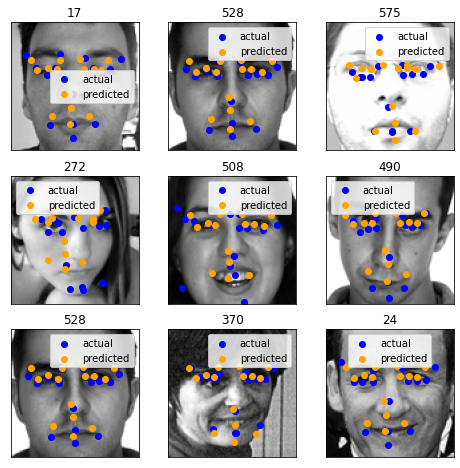

In [36]:
plot_keypoints_and_image(X_test, coords_actual, y_pred = coords_pred)

In [37]:
res = model.evaluate(X_test, y_test)

21/21 [==============================] - 0s 4ms/step - loss: 25.2669 - mae: 4.0082


### Data Augmentation

#### Rotation

In [38]:
def rotate_augmentation(images, keypoints, rotation_angles):
    rotated_images = []
    rotated_keypoints = []
    print("Augmenting for angles (in degrees): ")
    for angle in rotation_angles:    # Rotation augmentation for a list of angle values
        for angle in [angle]:
            print(f'{angle}', end='  ')
            M = cv2.getRotationMatrix2D((48,48), angle, 1.0)
            angle_rad = -angle*np.pi/180.     # Obtain angle in radians from angle in degrees (notice negative sign for change in clockwise vs anti-clockwise directions from conventional rotation to cv2's image rotation)
            # For train_images
            for image in images:
                rotated_image = cv2.warpAffine(image, M, (96,96), flags=cv2.INTER_CUBIC)
                rotated_images.append(rotated_image)
            # For train_keypoints
            for keypoint in keypoints:
                rotated_keypoint = keypoint - 48.    # Subtract the middle value of the image dimension
                for idx in range(0,len(rotated_keypoint),2):
                    # https://in.mathworks.com/matlabcentral/answers/93554-how-can-i-rotate-a-set-of-points-in-a-plane-by-a-certain-angle-about-an-arbitrary-point
                    rotated_keypoint[idx] = rotated_keypoint[idx]*np.cos(angle_rad)-rotated_keypoint[idx+1]*np.sin(angle_rad)
                    rotated_keypoint[idx+1] = rotated_keypoint[idx]*np.sin(angle_rad)+rotated_keypoint[idx+1]*np.cos(angle_rad)
                rotated_keypoint += 48.   # Add the earlier subtracted value
                rotated_keypoints.append(rotated_keypoint)
            
    return np.reshape(rotated_images,(-1,96,96,1)), rotated_keypoints

Augmenting for angles (in degrees): 
12  -12  
Shape of rotated_train_images: (4280, 96, 96, 1)
Shape of rotated_train_keypoints: (4280, 30)



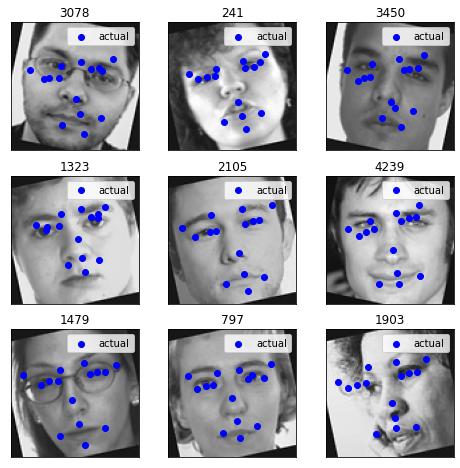

In [39]:
X_rotated, y_rotated = rotate_augmentation(X, y,[12,-12])
print("\nShape of rotated_train_images: {}".format(np.shape(X_rotated)))
print("Shape of rotated_train_keypoints: {}\n".format(np.shape(y_rotated)))
X_1 = np.concatenate((X, X_rotated))
y_1 = np.concatenate((y, y_rotated))
coords_rotated = get_coordinates(pd.DataFrame(y_rotated))
plot_keypoints_and_image(X_rotated, coords_rotated)

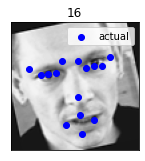

In [40]:
plot_keypoints_and_image(X_rotated, coords_rotated, img_number=1, id=16)

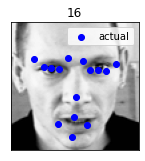

In [41]:
plot_keypoints_and_image(X, coords, img_number=1, id=16)

In [42]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_1, y_1, test_size=0.3, shuffle=True)

In [43]:
model = initialize_model()

In [44]:
history = model.fit(X_train1, y_train1, epochs=750, batch_size=32, validation_split=0.3, callbacks=[es])

Epoch 1/750
99/99 [==============================] - 1s 11ms/step - loss: 865.7642 - mae: 22.6965 - val_loss: 61.9146 - val_mae: 5.8757
Epoch 2/750
99/99 [==============================] - 1s 7ms/step - loss: 240.9675 - mae: 12.0292 - val_loss: 48.7710 - val_mae: 5.4894
Epoch 3/750
99/99 [==============================] - 1s 7ms/step - loss: 175.8038 - mae: 10.2488 - val_loss: 23.0926 - val_mae: 3.7246
Epoch 4/750
99/99 [==============================] - 1s 7ms/step - loss: 142.7569 - mae: 9.2017 - val_loss: 21.4371 - val_mae: 3.5948
Epoch 5/750
99/99 [==============================] - 1s 7ms/step - loss: 124.9373 - mae: 8.5843 - val_loss: 18.7984 - val_mae: 3.3801
Epoch 6/750
99/99 [==============================] - 1s 7ms/step - loss: 114.4165 - mae: 8.2085 - val_loss: 25.5892 - val_mae: 3.9906
Epoch 7/750
99/99 [==============================] - 1s 7ms/step - loss: 110.5194 - mae: 8.0142 - val_loss: 17.6063 - val_mae: 3.2682
Epoch 8/750
99/99 [==============================] - 1s 7m

In [45]:
res = model.evaluate(X_test1, y_test1)

61/61 [==============================] - 0s 4ms/step - loss: 25.0227 - mae: 4.0813


#### Horizontal Flipping Augmentation

In [46]:
def left_right_flip(images, keypoints):
    flipped_keypoints = []
    flipped_images = np.flip(images, axis=2)   # Flip column-wise (axis=2)
    for idx, sample_keypoints in enumerate(keypoints):
        flipped_keypoints.append([96.-coor if idx%2==0 else coor for idx,coor in enumerate(sample_keypoints)])    # Subtract only X co-ordinates of keypoints from 96 for horizontal flipping
    return flipped_images, flipped_keypoints 

Shape of flipped_train_images: (2140, 96, 96, 1)
Shape of flipped_train_keypoints: (2140, 30)


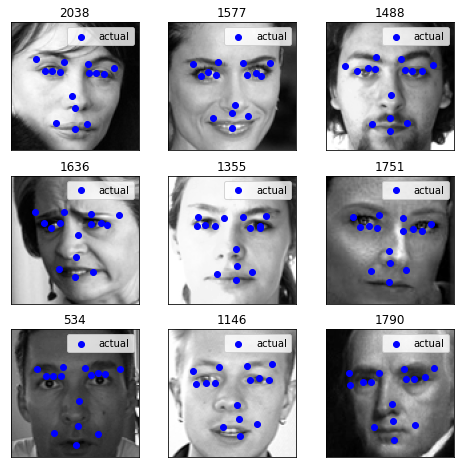

In [47]:
X_flipped, y_flipped = left_right_flip(X, y)
print("Shape of flipped_train_images: {}".format(np.shape(X_flipped)))
print("Shape of flipped_train_keypoints: {}".format(np.shape(y_flipped)))
X_2 = np.concatenate((X, X_flipped))
y_2 = np.concatenate((y, y_flipped))

coords_flipped = get_coordinates(pd.DataFrame(y_flipped))
plot_keypoints_and_image(X_flipped, coords_flipped)

In [48]:
model = initialize_model()
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_2, y_2, test_size=0.3, shuffle=True)

In [49]:
history = model.fit(X_train2, y_train2, epochs=750, batch_size=32, validation_split=0.3, callbacks=[es])

Epoch 1/750
66/66 [==============================] - 1s 11ms/step - loss: 1216.3403 - mae: 27.9589 - val_loss: 309.8631 - val_mae: 13.6245
Epoch 2/750
66/66 [==============================] - 0s 7ms/step - loss: 456.6808 - mae: 16.5776 - val_loss: 200.4693 - val_mae: 10.4545
Epoch 3/750
66/66 [==============================] - 1s 8ms/step - loss: 364.6788 - mae: 14.7552 - val_loss: 189.6753 - val_mae: 9.9463
Epoch 4/750
66/66 [==============================] - 0s 7ms/step - loss: 334.5033 - mae: 14.0791 - val_loss: 174.3370 - val_mae: 9.1292
Epoch 5/750
66/66 [==============================] - 0s 7ms/step - loss: 307.1016 - mae: 13.4567 - val_loss: 174.1533 - val_mae: 9.1570
Epoch 6/750
66/66 [==============================] - 0s 7ms/step - loss: 290.1974 - mae: 13.0653 - val_loss: 172.6174 - val_mae: 9.0493
Epoch 7/750
66/66 [==============================] - 0s 7ms/step - loss: 277.0045 - mae: 12.7160 - val_loss: 188.1729 - val_mae: 10.0758
Epoch 8/750
66/66 [========================

In [50]:
res = model.evaluate(X_test2, y_test2)

41/41 [==============================] - 0s 4ms/step - loss: 115.9818 - mae: 7.1453


#### Brightness Augmentation

In [51]:
def alter_brightness(images, keypoints):
    altered_brightness_images = []
    inc_brightness_images = np.clip(images*1.2, 0.0, 1.0)    # Increased brightness by a factor of 1.2 & clip any values outside the range of [-1,1]
    dec_brightness_images = np.clip(images*0.6, 0.0, 1.0)    # Decreased brightness by a factor of 0.6 & clip any values outside the range of [-1,1]
    altered_brightness_images.extend(inc_brightness_images)
    altered_brightness_images.extend(dec_brightness_images)
    return altered_brightness_images, np.concatenate((keypoints, keypoints))

Shape of altered_brightness_train_images: (4280, 96, 96, 1)
Shape of altered_brightness_train_keypoints: (4280, 30)


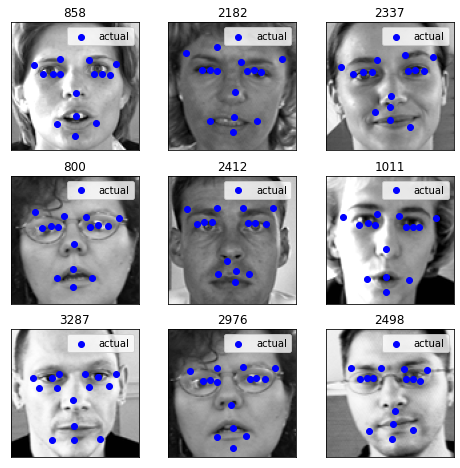

In [52]:
X_bright, y_bright = alter_brightness(X, y)
print(f"Shape of altered_brightness_train_images: {np.shape(X_bright)}")
print(f"Shape of altered_brightness_train_keypoints: {np.shape(y_bright)}")
X_3 = np.concatenate((X, X_bright))
y_3 = np.concatenate((y, y_bright))

coords_bright = get_coordinates(pd.DataFrame(y_bright))
plot_keypoints_and_image(X_bright, coords_bright)

In [53]:
def visualize(original, augmented):
  fig = plt.figure()
  plt.subplot(1,2,1)
  plt.title('Original image')
  plt.imshow(original, cmap='gray')

  plt.subplot(1,2,2)
  plt.title('Augmented image')
  plt.imshow(augmented, cmap='gray')

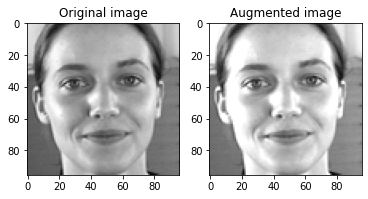

In [54]:
visualize(X[9].reshape(96,96), X_bright[9].reshape(96,96))

In [55]:
model = initialize_model()
X_train3, X_test3, y_train3, y_test3 = train_test_split(X_3, y_3, test_size=0.3, shuffle=True)

In [56]:
history = model.fit(X_train3, y_train3, epochs=750, batch_size=32, validation_split=0.3, callbacks=[es])

Epoch 1/750
99/99 [==============================] - 1s 9ms/step - loss: 827.2227 - mae: 22.1170 - val_loss: 62.5253 - val_mae: 6.0928
Epoch 2/750
99/99 [==============================] - 1s 7ms/step - loss: 237.2810 - mae: 11.8703 - val_loss: 33.6595 - val_mae: 4.6029
Epoch 3/750
99/99 [==============================] - 1s 7ms/step - loss: 174.3583 - mae: 10.0912 - val_loss: 13.4334 - val_mae: 2.7222
Epoch 4/750
99/99 [==============================] - 1s 7ms/step - loss: 145.9981 - mae: 9.2204 - val_loss: 46.7860 - val_mae: 5.7044
Epoch 5/750
99/99 [==============================] - 1s 7ms/step - loss: 127.9929 - mae: 8.5928 - val_loss: 21.9893 - val_mae: 3.7336
Epoch 6/750
99/99 [==============================] - 1s 7ms/step - loss: 113.0836 - mae: 8.0474 - val_loss: 17.9606 - val_mae: 3.2657
Epoch 7/750
99/99 [==============================] - 1s 7ms/step - loss: 106.2040 - mae: 7.7907 - val_loss: 12.8328 - val_mae: 2.7008
Epoch 8/750
99/99 [==============================] - 1s 7ms

In [57]:
res = model.evaluate(X_test3, y_test3)

61/61 [==============================] - 0s 4ms/step - loss: 21.6289 - mae: 3.7016


In [58]:
X.shape

(2140, 96, 96, 1)

In [59]:
y.shape

(2140, 30)

In [60]:
coords.shape

(32100, 2)

In [61]:
coords[0]

array([66.03356391, 39.00227368])

In [62]:
theta = 30*np.pi/180.
temp = np.array(coords)
temp1 = np.array(coords-48)
temp1[:,0] = (coords[:,0]-48)*np.cos(theta)+(coords[:,1]-48)*np.sin(theta)
temp1[:,1] = (coords[:,1]-48)*np.cos(theta)-(coords[:,0]-48)*np.sin(theta)
temp1[:,0] += 48
temp1[:,1] += 48

In [63]:
temp1[0]

array([59.11866131, 31.19095848])

In [64]:
import tensorflow as tf

In [65]:
t = tf.image.rotate(X[0], angles=30)

AttributeError: ignored

In [ ]:
plt.title('Augmented image')
plt.imshow(t[:, :, 0], cmap='gray')
plt.scatter(temp1[0:15,0], temp1[0:15,1])

In [ ]:
visualize(X[0].reshape(96,96), t[:, :, 0])

In [75]:
path_image1 = glob.glob('/content/drive/MyDrive/Deep_learning_data/keypoints-images/image_test1.jpeg')

In [76]:
image1 = imageio.imread(str(path_image1[0]))

In [80]:
image1.shape

(183, 276, 3)

In [81]:
np.reshape(image1, (len(image1),96,96,1))

ValueError: ignored

In [79]:
preprocess(image1)

ValueError: ignored

### Try on youtube data set

In [ ]:
import glob

In [ ]:
videoDF = pd.read_csv('../raw_data/youtube_faces_with_keypoints_full.csv')
videoDF.head(5)

In [ ]:
npzFilesFullPath = glob.glob('../raw_data/*.npz')
videoIDs = [x.split('/')[-1].split('.')[0] for x in npzFilesFullPath]
fullPaths = {}
for videoID, fullPath in zip(videoIDs, npzFilesFullPath):
    fullPaths[videoID] = fullPath

In [ ]:
videoDF = videoDF[videoDF['personName']=='Pat_Riley']

In [ ]:
videoDF

In [ ]:
np.random.seed(3)
numVideos = 4
framesToShowFromVideo = np.array([0.1,0.5,0.9])
numFramesPerVideo = len(framesToShowFromVideo)

rigthEyebrowPoints = [17,22]
leftEyebrowPoints  = [22,27]
noseBasePoints     = [31]
rightEyePoints     = [36,38,39,41]
leftEyePoints      = [42,44,46, 47]
outerMouthPoints   = [48,51, 63,60]

listOfAllConnectedPoints = [rigthEyebrowPoints,leftEyebrowPoints,
                            noseBasePoints,rightEyePoints,
                            leftEyePoints,outerMouthPoints]
videoFile = np.load(fullPaths['Pat_Riley_0'])
colorImages = videoFile['colorImages']
boundingBox = videoFile['boundingBox']
landmarks2D = videoFile['landmarks2D']
landmarks3D = videoFile['landmarks3D']

fig, axArray = plt.subplots(nrows=numVideos,ncols=numFramesPerVideo,figsize=(14,18))

videoFile = np.load(fullPaths[videoID])
colorImages = videoFile['colorImages']
boundingBox = videoFile['boundingBox']
landmarks2D = videoFile['landmarks2D']
landmarks3D = videoFile['landmarks3D']

selectedFrames = (framesToShowFromVideo*(colorImages.shape[3]-1)).astype(int)
plt.imshow(colorImages[:,:,:,frameInd])
plt.scatter(x=landmarks2D[:,0,frameInd],y=landmarks2D[:,1,frameInd],s=9,c='r')
for conPts in listOfAllConnectedPoints:
    xPts = landmarks2D[conPts[0]:conPts[-1],0,frameInd]
    yPts = landmarks2D[conPts[0]:conPts[-1],1,frameInd]
    plt.scatter(xPts,yPts,c='w',lw=1)